In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import torch

from tqdm import tqdm_notebook as tqdm

In [2]:
plt.rcParams["font.family"] = 'DejaVu Sans'

plt.rcParams['text.usetex'] = True

In [3]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 36
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=36
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = 40

In [4]:
color = ['blue', 'red', 'black', 'black', 'black']

In [5]:
from MixtureLib.Mixture import MixtureEM
from MixtureLib.LocalModels import EachModelLinear
from MixtureLib.HyperModels import HyperExpertNN, HyperModelDirichlet


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [7]:
np.random.seed(0)
N = 100
n = 2

w1 = np.random.randn(n)
X1 = np.random.multivariate_normal(-3*np.ones(n), np.eye(n), size = N)

w2 = np.random.randn(n)
X2 = np.random.multivariate_normal(3*np.ones(n), np.eye(n), size = N)

X = np.vstack([X1, X2])

Y = np.vstack([X1@w1, X2@w2])


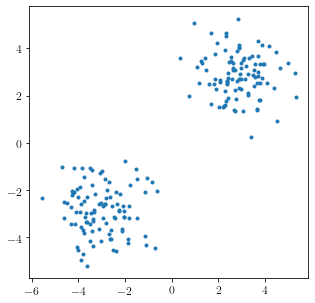

In [8]:
FONT_SIZE = 12

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE
plt.rcParams['axes.titlesize']=FONT_SIZE
plt.rcParams['axes.labelsize']=FONT_SIZE
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams['font.size'] = FONT_SIZE
##############################################

_ = plt.plot(X[:, 0], X[:, 1], '.')

In [9]:
W_true = np.array([w1, w2])

In [10]:
X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(Y).view([-1,1])

X_tr.shape, Y_tr.shape

(torch.Size([200, 2]), torch.Size([200, 1]))

# Mixture of Model Picture

In [11]:
K = 2
epoch = 100

In [12]:
List_of_ind = []
List_of_W = []

LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, device = device))

HypPar = {'beta': 1}

HpMd = HyperModelDirichlet(output_dim = K, device = device)

model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)

for _ in tqdm(range(epoch)):
    model.fit(X_tr, Y_tr, 1, progress = None)
    List_of_ind.append(np.argmax(model.predict(X_tr)[1], axis = 1))
    List_of_W.append(np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels]))
    
List_of_ind = np.array(List_of_ind)
List_of_W = np.array(List_of_W)


In [13]:
np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

array([[1.7649927 , 0.39867783],
       [1.0984211 , 0.657114  ]], dtype=float32)

In [14]:
W_true

array([[1.76405235, 0.40015721],
       [1.0996596 , 0.65526373]])

In [15]:
((Y_tr-model.predict(X_tr)[0])**2).mean()

tensor(0.4977)

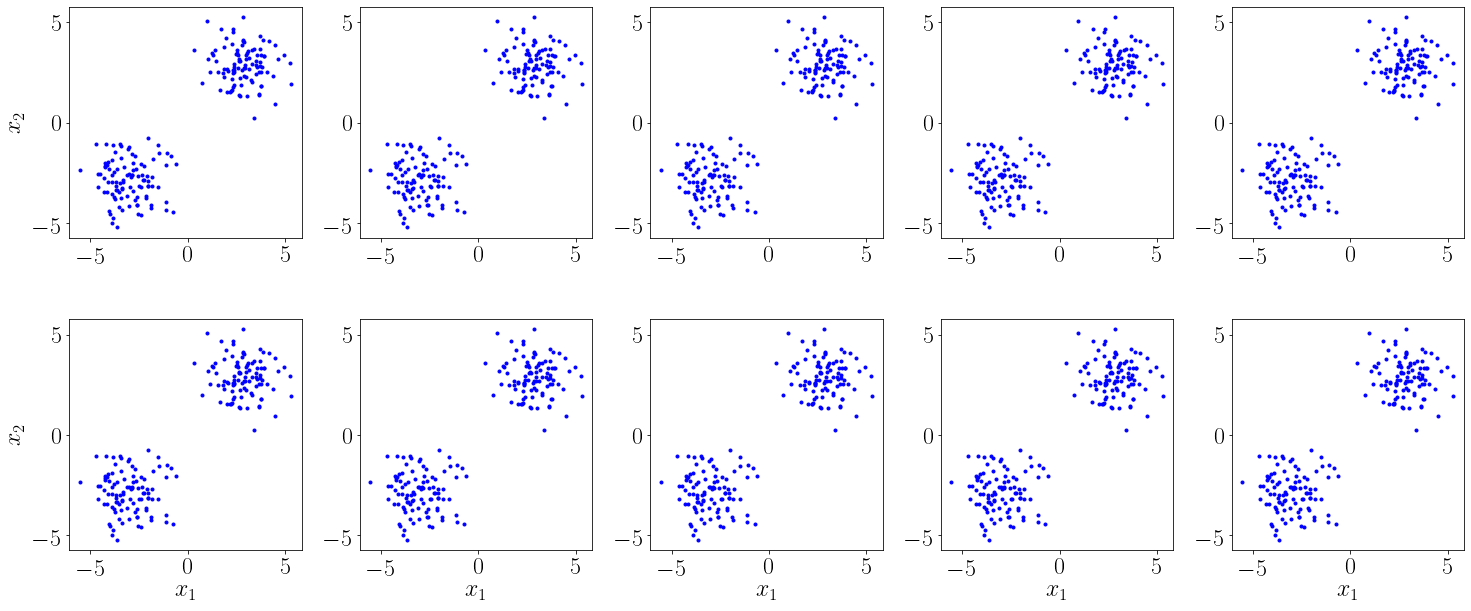

In [16]:
FONT_SIZE = 24

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE
plt.rcParams['axes.titlesize']=FONT_SIZE
plt.rcParams['axes.labelsize']=FONT_SIZE
plt.rcParams['figure.figsize'] = (25.0, 10.0)
plt.rcParams['font.size'] = FONT_SIZE
##############################################

t = np.linspace(0, 2*np.pi, 100)

colors = color


fig = plt.figure();

gs = gridspec.GridSpec(2, 5)

ax = []
for i, g in enumerate(gs):
    ax.append(fig.add_subplot(g))
    if (len(ax) - 1) % 5 == 0:
        ax[-1].set_ylabel('$x_2$')
    if len(ax) > 5:
        ax[-1].set_xlabel('$x_1$')
    
IDX = np.arange(0, 100 , 10)
    
for e, (idx, _) in enumerate(zip(List_of_ind[IDX], List_of_W[IDX])):
    for i in np.unique(idx):
        indexes = np.where(idx == i)
        _ = ax[e].plot(X[indexes, 0], X[indexes, 1], '.', color=color[i])

plt.subplots_adjust(wspace=0.25, hspace=0.35)
        
plt.show()

# Mixture of Experts Picture

In [17]:
K = 2
epoch = 10

In [18]:
List_of_ind = []
List_of_W = []

LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, device = device))

HypPar = {'beta': 1}

HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)

model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)

for _ in tqdm(range(epoch)):
    model.fit(X_tr, Y_tr, 1, progress = None)
    List_of_ind.append(np.argmax(model.predict(X_tr)[1], axis = 1))
    List_of_W.append(np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels]))
    

In [19]:
np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

array([[1.7636051 , 0.40072918],
       [1.0997148 , 0.6551995 ]], dtype=float32)

In [20]:
W_true

array([[1.76405235, 0.40015721],
       [1.0996596 , 0.65526373]])

In [21]:
((Y_tr-model.predict(X_tr)[0])**2).mean()

tensor(0.0003)

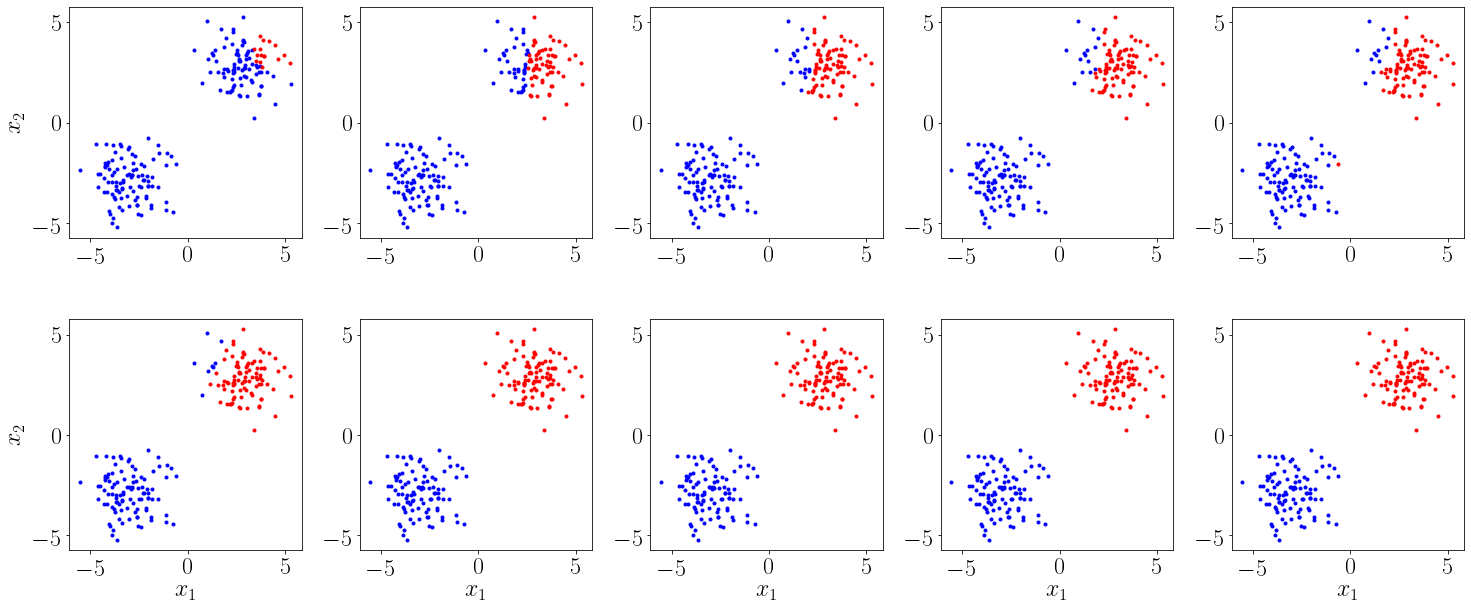

In [22]:
FONT_SIZE = 24

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE
plt.rcParams['axes.titlesize']=FONT_SIZE
plt.rcParams['axes.labelsize']=FONT_SIZE
plt.rcParams['figure.figsize'] = (25.0, 10.0)
plt.rcParams['font.size'] = FONT_SIZE
##############################################

t = np.linspace(0, 2*np.pi, 100)

colors = color


fig = plt.figure();

gs = gridspec.GridSpec(2, 5)

ax = []
for i, g in enumerate(gs):
    ax.append(fig.add_subplot(g))
    if (len(ax) - 1) % 5 == 0:
        ax[-1].set_ylabel('$x_2$')
    if len(ax) > 5:
        ax[-1].set_xlabel('$x_1$')
    

for e, (idx, _) in enumerate(zip(List_of_ind[:10], List_of_W[:10])):
    for i in np.unique(idx):
        indexes = np.where(idx == i)
        _ = ax[e].plot(X[indexes, 0], X[indexes, 1], '.', color=color[i])

plt.subplots_adjust(wspace=0.25, hspace=0.35)
        
plt.show()